# Image Classifier for Dogs and Cats

## Features:
    1. Data augmentation

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

%matplotlib inline

plt.rcParams['figure.figsize'] = 15, 8

In [2]:
from keras import Input, Model
from keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Dropout
from keras import optimizers, losses, metrics
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.preprocessing import image

Using TensorFlow backend.


In [3]:
datagen = ImageDataGenerator(rescale=1.0/255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

In [4]:
DATADIR = '/Volumes/Study/GitHub/data/cats-dogs/'
train_cat_dir = os.path.join(DATADIR + 'training/cats/')

In [5]:
image_list = [os.path.join(train_cat_dir, image) for image in os.listdir(train_cat_dir)]
single_image = image_list[3]

In [6]:
len(image_list)

1001

In [7]:
img = image.load_img(single_image, target_size=(150, 150))

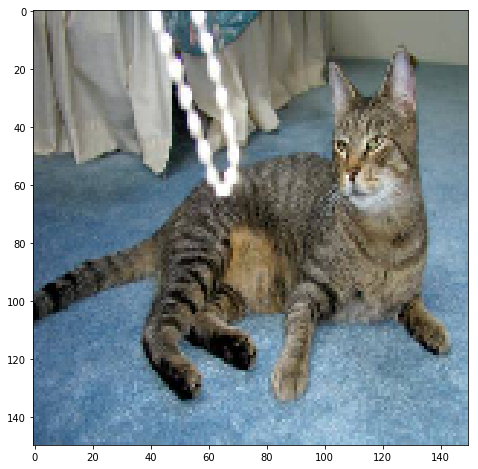

In [8]:
plt.imshow(img)
plt.show()

In [9]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x.shape

(1, 150, 150, 3)

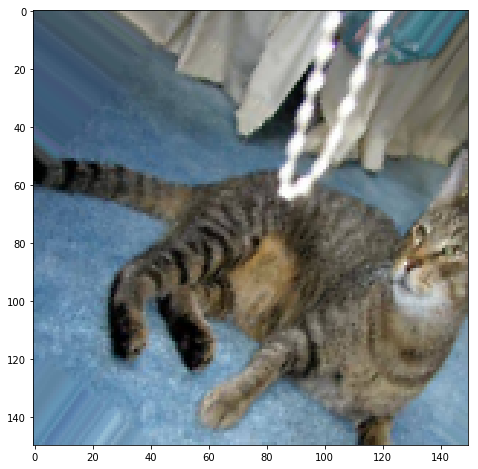

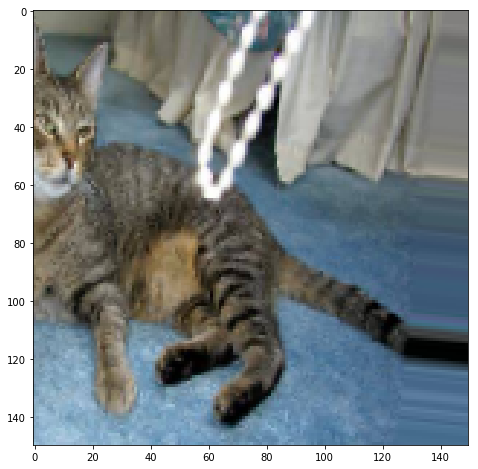

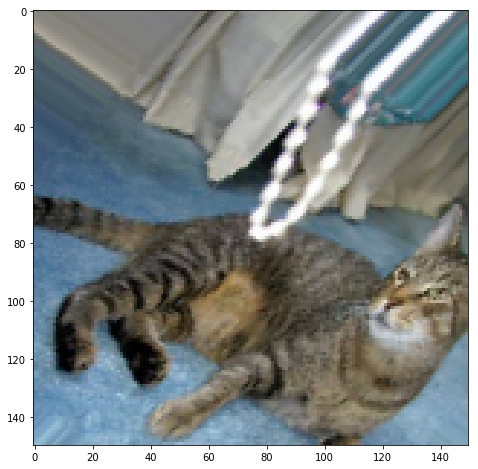

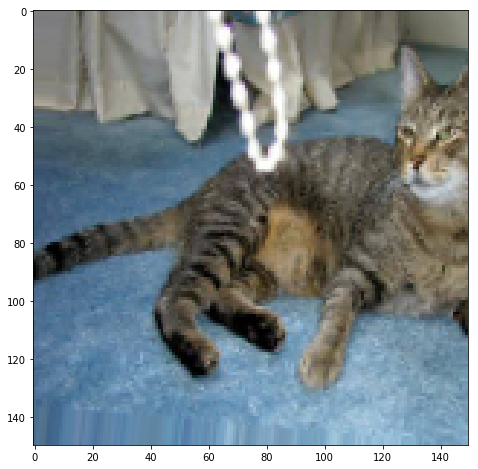

In [10]:
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    plt.imshow(image.array_to_img(batch[0]))
    i +=1
    if i==4:
        break
plt.show()

In [11]:
class CatsAndDogs:

    def __init__(self, loss='binary', metric='binary',
                 optimizer='adam', lr=1e-4, epochs=20, image_size=150,
                 batch_size=20, augmentation=True, plotting=True,
                 dropout=False, regularizer=False):

        self.loss = loss
        self.metric = metric
        self.optimizer = optimizer
        self.lr = lr
        self.epochs = epochs
        self.image_size = image_size
        self.batch_size = batch_size
        self.augmentation = augmentation
        self.plotting = plotting
        self.dropout = dropout
        self.regularizer = regularizer
        self.DATADIR = None
        self.LOGDIR = None

    def _load_data(self):

        self.DATADIR = '/Volumes/Study/GitHub/data/cats-dogs/'
        self.LOGDIR = '/Volumes/Study/GitHub/neural-nets/graphs/cats-dogs/'

        if not os.path.exists(self.LOGDIR):
            os.mkdir(self.LOGDIR, 755)
            
        print('Data directory',self.DATADIR)
        print('Log directory:',self.LOGDIR)
        
        self.train_dir = os.path.join(self.DATADIR + 'training/')
        self.validation_dir = os.path.join(self.DATADIR + 'validation/')
        self.test_dir = os.path.join(self.DATADIR + 'test/')

    def data_generator(self):
        if self.augmentation:
            train_datagen = ImageDataGenerator(rescale=1.0/255,
                                               rotation_range=40,
                                               width_shift_range=0.2,
                                               height_shift_range=0.2,
                                               shear_range=0.2,
                                               zoom_range=0.2,
                                               horizontal_flip=True,
                                               fill_mode='nearest')

            validation_datagen = ImageDataGenerator(rescale=1./255)

        else:
            train_datagen = ImageDataGenerator(rescale=1.0/255)
            validation_datagen = ImageDataGenerator(rescale=1.0/255)

        train_generator = train_datagen.flow_from_directory(
                                            self.train_dir,
                                            classes=['cats', 'dogs'],
                                            target_size=(self.image_size, self.image_size),
                                            batch_size=self.batch_size,
                                            class_mode='binary')
        validation_generator = validation_datagen.flow_from_directory(
                                            self.validation_dir,
                                            classes=['cats', 'dogs'],
                                            target_size=(self.image_size, self.image_size),
                                            batch_size=self.batch_size,
                                            class_mode='binary')

        return train_generator, validation_generator

    def model_building(self):

        ip = Input(batch_shape=(None, self.image_size, self.image_size, 3), name='input')

        x = Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', name='conv1')(ip)
        x = MaxPool2D(pool_size=(2, 2), name='pool1')(x)

        x = Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', name='conv2')(x)
        x = MaxPool2D(pool_size=(2, 2), name='pool2')(x)

        x = Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu', name='conv3')(x)
        x = MaxPool2D(pool_size=(2, 2), name='pool3')(x)

        x = Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu', name='conv4')(x)
        x = MaxPool2D(pool_size=(2, 2), name='pool4')(x)

        x = Flatten(name='flatten')(x)
        if self.dropout:
            x = Dropout(rate=0.3, name='dropout1')(x)

        x = Dense(units=128, activation='relu', name='dense1')(x)
        if self.dropout:
            x = Dropout(rate=0.3, name='dropout2')(x)

        output = Dense(units=1, activation='sigmoid', name='output')(x)

        model = Model(inputs=ip, outputs=output)

        return model

    def training_parameters(self):

        if self.optimizer == 'adam':
            opt = optimizers.adam(self.lr)
        elif self.optimizer == 'rms':
            opt = optimizers.RMSprop(self.lr)

        if self.loss == 'binary':
            loss = losses.binary_crossentropy
        elif self.loss == 'multiclass':
            loss = losses.categorical_crossentropy

        if self.metric == 'binary':
            accuracy = metrics.binary_accuracy
        elif self.metric == 'multiclass':
            accuracy = metrics.categorical_crossentropy

        return opt, loss, accuracy

    def training(self):

        self._load_data()

        model = self.model_building()
        model.summary()

        train_generator, validation_generator = self.data_generator()

        opt, loss, accuracy = self.training_parameters()
        model.compile(loss=loss, optimizer=opt, metrics=[accuracy])

        history = model.fit_generator(train_generator,
                                      steps_per_epoch=100,
                                      epochs=self.epochs,
                                      verbose=2,
                                      validation_data=validation_generator,
                                      validation_steps=50)

        model.save(os.path.join(self.LOGDIR + 'cat_dog_v2_1.h5'))

        if self.plotting:

            plt.plot(history.history['loss'], label='training_loss')
            plt.plot(history.history['val_loss'], label='validation_loss')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Training and Validation loss')
            plt.legend()
            plt.show()

            plt.plot(history.history['binary_accuracy'], label='training_accuracy')
            plt.plot(history.history['val_binary_accuracy'], label='validation_accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.title('Training and Validation Accuracy')
            plt.legend()
            plt.show()

        return

In [12]:
# model = CatsAndDogs(loss='binary', metric='binary',
#                     optimizer='adam', lr=1e-4, epochs=20, image_size=150,
#                     batch_size=20, augmentation=True, plotting=True,
#                     dropout=False, regularizer=False)

In [13]:
# model.training()

In [14]:
from keras.models import load_model

In [15]:
LOGDIR = '/Volumes/Study/GitHub/neural-nets/graphs/cats-dogs/'

In [16]:
model = load_model(os.path.join(LOGDIR, 'cat_dog_v2_1.h5'))

In [17]:
test_dir = '/Volumes/Study/GitHub/data/cats-dogs/test/'

In [18]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

In [19]:
test_generator = test_datagen.flow_from_directory(test_dir,
                                                 target_size=(150, 150),
                                                 batch_size=1,
                                                 shuffle=False,
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


In [20]:
model.evaluate_generator(test_generator)

[0.4969037559777062, 0.743]

In [21]:
test_generator.reset()

In [22]:
nb = len(test_generator.filenames)

In [23]:
test_generator.class_indices

{'cats': 0, 'dogs': 1}

In [24]:
test_generator.filenames

['cats/cat.1501.jpg',
 'cats/cat.1502.jpg',
 'cats/cat.1503.jpg',
 'cats/cat.1504.jpg',
 'cats/cat.1505.jpg',
 'cats/cat.1506.jpg',
 'cats/cat.1507.jpg',
 'cats/cat.1508.jpg',
 'cats/cat.1509.jpg',
 'cats/cat.1510.jpg',
 'cats/cat.1511.jpg',
 'cats/cat.1512.jpg',
 'cats/cat.1513.jpg',
 'cats/cat.1514.jpg',
 'cats/cat.1515.jpg',
 'cats/cat.1516.jpg',
 'cats/cat.1517.jpg',
 'cats/cat.1518.jpg',
 'cats/cat.1519.jpg',
 'cats/cat.1520.jpg',
 'cats/cat.1521.jpg',
 'cats/cat.1522.jpg',
 'cats/cat.1523.jpg',
 'cats/cat.1524.jpg',
 'cats/cat.1525.jpg',
 'cats/cat.1526.jpg',
 'cats/cat.1527.jpg',
 'cats/cat.1528.jpg',
 'cats/cat.1529.jpg',
 'cats/cat.1530.jpg',
 'cats/cat.1531.jpg',
 'cats/cat.1532.jpg',
 'cats/cat.1533.jpg',
 'cats/cat.1534.jpg',
 'cats/cat.1535.jpg',
 'cats/cat.1536.jpg',
 'cats/cat.1537.jpg',
 'cats/cat.1538.jpg',
 'cats/cat.1539.jpg',
 'cats/cat.1540.jpg',
 'cats/cat.1541.jpg',
 'cats/cat.1542.jpg',
 'cats/cat.1543.jpg',
 'cats/cat.1544.jpg',
 'cats/cat.1545.jpg',
 'cats/cat

In [25]:
predictions = model.predict_generator(test_generator, steps=nb)

In [26]:
predictions.shape

(1000, 1)

In [27]:
predictions[:5]

array([[0.801361  ],
       [0.706556  ],
       [0.519826  ],
       [0.42006403],
       [0.3000878 ]], dtype=float32)